# Imports

In [119]:
import os
import sys
import itertools
from collections import defaultdict

import scipy.sparse as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from adjustText import adjust_text

from PIL import Image
import requests
from io import BytesIO

import cornac
from cornac.utils import cache
from cornac.data import Dataset
from cornac.eval_methods import RatioSplit
from cornac.models import MF, WMF, EASE, VBPR, CTR
from cornac.models.dmrl import DMRL
from cornac.data import TextModality, ImageModality

import tensorflow as tf

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")
print(f"Tensorflow version: {tf.__version__}")

SEED = 42
VERBOSE = False

System version: 3.9.19 (main, Mar 21 2024, 17:21:27) [MSC v.1916 64 bit (AMD64)]
Cornac version: 2.1
Tensorflow version: 2.16.1


# Load dataset

In [3]:
# ratings.csv straight from kaggle
ratings_path = '../data/01_raw/rating.csv'

# anime_final_cleaned.csv is a processed csv file combined from kaggle and scraping
# where anime without either a synopsis and/or a cover image were removed from the df.
anime_path = '../data/03_primary/anime_final_cleaned.csv'

In [4]:
ratings = pd.read_csv(ratings_path)
content = pd.read_csv(anime_path)

In [75]:
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [76]:
content.head()

,anime_id,name,type,episodes,mal_score,members,studio,release-season,release-year,release-date,...,themes,demographics,synopsis,image_url,rating,va_list,staff_list,recommended_review_count,mixedfeelings_review_count,notrecommended_review_count
0,1,Cowboy Bebop,TV,26,8.82,486824,['Sunrise'],spring,1998.0,NaN,...,[],NaN,"Crime is timeless. By the year 2071, humanity ...",https://cdn.myanimelist.net/images/anime/4/196...,R - 17+ (violence & profanity),"['Yamadera, Kouichi', 'Hayashibara, Megumi', '...","['Cook, Justin', 'Maseba, Yutaka', 'Minami, Ma...",539,38,17
1,5,Cowboy Bebop: Tengoku no Tobira,Movie,1,8.40,137636,['Bones'],summer,2001.0,NaN,...,[],NaN,"Another day, another bounty—such is the life o...",https://cdn.myanimelist.net/images/anime/1439/...,R - 17+ (violence & profanity),"['Yamadera, Kouichi', 'Hayashibara, Megumi', '...","['Maseba, Yutaka', 'Minami, Masahiko', 'Ueda, ...",62,8,3
2,6,Trigun,TV,26,8.32,283069,['Madhouse'],spring,1998.0,NaN,...,['Adult Cast'],Shounen,"Vash the Stampede is the man with a $$60,000,0...",https://cdn.myanimelist.net/images/anime/7/203...,PG-13 - Teens 13 or older,"['Onosaka, Masaya', 'Hayami, Show', 'Yukino, S...","['Cook, Justin', 'Maseba, Yutaka', 'Kitayama, ...",151,16,9
3,7,Witch Hunter Robin,TV,26,7.36,64905,['Sunrise'],summer,2002.0,NaN,...,[],NaN,Robin Sena is a powerful craft user drafted in...,https://cdn.myanimelist.net/images/anime/10/19...,PG-13 - Teens 13 or older,"['Watanabe, Akeno', 'Takewaka, Takuma', 'Yuuki...","['Murase, Shukou', 'Fujino, Sadayoshi', 'Miyat...",28,6,4
4,8,Beet the Vandel Buster,TV,52,7.06,9848,['Toei Animation'],fall,2004.0,NaN,...,[],NaN,It is the dark century and the people are suff...,https://cdn.myanimelist.net/images/anime/7/215...,PG - Children,"['Kiuchi, Reiko', 'Hisakawa, Aya', 'Miura, Hir...","['Seki, Hiromi', 'Nagamine, Tatsuya', 'Yamauch...",3,1,0


# Preprocessing

In [7]:
# clean user_id
all_users = ratings['user_id'].unique()
print(f"number of users = {len(all_users)}")

number of users = 73515


In [8]:
print(f"user_id ranges from: {ratings['user_id'].min()} to {ratings['user_id'].max()}")

user_id ranges from: 1 to 73516


There is a single missing user_id within the range. To find out the missing value and remap the user_ids.

In [9]:
max = ratings['user_id'].max()
# use property of arithmetic series :) (thanks leetcode! O(1))
missing = (max * (max+1)) / 2 - all_users.sum()
missing

46809.0

In [10]:
# double check whether that really is the missing user_id
id_46809_in_users = 46809 in all_users
id_46809_in_users

False

In [11]:
# double check whether all other values are present in the column. O(n)
all_users_set = set(all_users)
all_others_present = True
for user in range(1, ratings['user_id'].max() + 1):
    if user == 46809:
        continue
    else:
        if user in all_users_set:
            continue
        all_others_present = False
        break
    
all_others_present

True

In [12]:
# instead of remapping the entire user_id column, we can just change the id of last user 73516 to 46809.
ratings[ratings["user_id"]==73516]

,user_id,anime_id,rating
7813735,73516,790,9
7813736,73516,8074,9


In [13]:
ratings["user_id"] = ratings["user_id"].replace(73516, 46809)
ratings[ratings["user_id"]==46809]

,user_id,anime_id,rating
7813735,46809,790,9
7813736,46809,8074,9


In [14]:
# discard ratings for items not in final anime list
filtered_ratings = pd.merge(
    content, 
    ratings, 
    on="anime_id", 
    how="left", 
    suffixes=["_left", ""]
)[["user_id", "anime_id", "rating"]].sort_values(by=['user_id'])

filtered_ratings

,user_id,anime_id,rating
4458436,1,8407,-1
5764696,1,13411,-1
4946889,1,10073,-1
5755528,1,13367,-1
4950590,1,10076,-1
...,...,...,...
2349703,73515,1818,9
1038389,73515,411,9
5471551,73515,11751,6
4172236,73515,6919,7


In [15]:
# find out how many ratings were lost due to missing synopsis and/or cover image
print(f"lost ratings due to missing synopsis and/or cover image {len(ratings) - len(filtered_ratings)}")

lost ratings due to missing synopsis and/or cover image 6063


In [16]:
# reindex items
anime_remap = {}
sorted_content = content.sort_values(by=['anime_id'])
all_anime = sorted_content['anime_id'].unique()

counter = 1
for anime in all_anime:
    anime_remap[anime] = counter
    counter += 1

content["anime_id_remapped"] = content["anime_id"].map(anime_remap)
content.head()

,anime_id,name,type,episodes,mal_score,members,studio,release-season,release-year,release-date,...,demographics,synopsis,image_url,rating,va_list,staff_list,recommended_review_count,mixedfeelings_review_count,notrecommended_review_count,anime_id_remapped
0,1,Cowboy Bebop,TV,26,8.82,486824,['Sunrise'],spring,1998.0,NaN,...,NaN,"Crime is timeless. By the year 2071, humanity ...",https://cdn.myanimelist.net/images/anime/4/196...,R - 17+ (violence & profanity),"['Yamadera, Kouichi', 'Hayashibara, Megumi', '...","['Cook, Justin', 'Maseba, Yutaka', 'Minami, Ma...",539,38,17,1
1,5,Cowboy Bebop: Tengoku no Tobira,Movie,1,8.40,137636,['Bones'],summer,2001.0,NaN,...,NaN,"Another day, another bounty—such is the life o...",https://cdn.myanimelist.net/images/anime/1439/...,R - 17+ (violence & profanity),"['Yamadera, Kouichi', 'Hayashibara, Megumi', '...","['Maseba, Yutaka', 'Minami, Masahiko', 'Ueda, ...",62,8,3,2
2,6,Trigun,TV,26,8.32,283069,['Madhouse'],spring,1998.0,NaN,...,Shounen,"Vash the Stampede is the man with a $$60,000,0...",https://cdn.myanimelist.net/images/anime/7/203...,PG-13 - Teens 13 or older,"['Onosaka, Masaya', 'Hayami, Show', 'Yukino, S...","['Cook, Justin', 'Maseba, Yutaka', 'Kitayama, ...",151,16,9,3
3,7,Witch Hunter Robin,TV,26,7.36,64905,['Sunrise'],summer,2002.0,NaN,...,NaN,Robin Sena is a powerful craft user drafted in...,https://cdn.myanimelist.net/images/anime/10/19...,PG-13 - Teens 13 or older,"['Watanabe, Akeno', 'Takewaka, Takuma', 'Yuuki...","['Murase, Shukou', 'Fujino, Sadayoshi', 'Miyat...",28,6,4,4
4,8,Beet the Vandel Buster,TV,52,7.06,9848,['Toei Animation'],fall,2004.0,NaN,...,NaN,It is the dark century and the people are suff...,https://cdn.myanimelist.net/images/anime/7/215...,PG - Children,"['Kiuchi, Reiko', 'Hisakawa, Aya', 'Miura, Hir...","['Seki, Hiromi', 'Nagamine, Tatsuya', 'Yamauch...",3,1,0,5


In [17]:
filtered_ratings["anime_id_remapped"] = filtered_ratings["anime_id"].map(anime_remap)
filtered_ratings.head()

,user_id,anime_id,rating,anime_id_remapped
4458436,1,8407,-1,5329
5764696,1,13411,-1,6921
4946889,1,10073,-1,6016
5755528,1,13367,-1,6910
4950590,1,10076,-1,6019


In [18]:
# map came from content dataframe, double check if filtered_ratings was remapped properly
filtered_ratings["anime_id_remapped"].isna().sum()

0

In [19]:
# take only the columns we want
ratings_cleaned = filtered_ratings[["user_id", "anime_id_remapped", "rating"]]

## Sparsity calculation

In [159]:
number_of_users = ratings_cleaned['user_id'].max()
number_of_items = len(content)
numner_of_interactions = len(ratings_cleaned)

sparsity = 1 - numner_of_interactions / (number_of_users * number_of_items)
print(f"sparsity: {sparsity}")

sparsity: 0.9904267908224452


# Explore different encodings

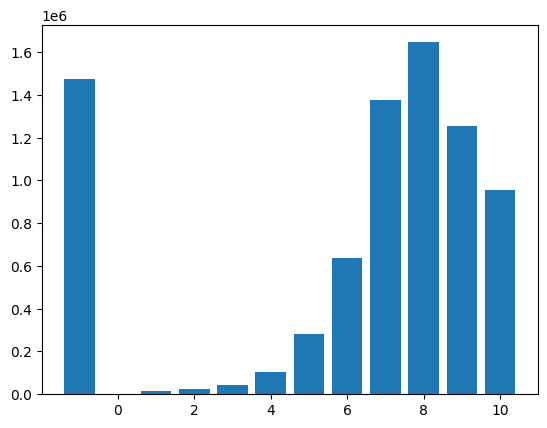

In [156]:
ratings_vc = ratings_cleaned["rating"].value_counts().sort_index()
rating_values, rating_counts = list(ratings_vc.index), list(ratings_vc.values)
plt.bar(rating_values, rating_counts)
plt.show()

Users tend to rate anime with fairly high ratings, the most comming rating is 8. Ratings above 7 make up the majority of ratings. A sizable portion of interations are unrated.

## Imputation methods
Kaggle dataset encoding "Watched but not rated" as -1 may cause such anime to be devalued as compared to unwatched anime. Plan to explore different encoding representations

- leave "watched but not rated" as -1
- convert them to 0.5 (just above unwatched, but that means less value than a 1 star rated anime which the user thinks is bad)
- convert them to 5 (middle of the scale, but everyone's middle may be different. It seems users tend to rate a bit higher anyway so 5 may not be the best midpoint)
- convert them to 7 (just below the "high" ratings)

It may also be valuable to explore if binning scores can improve the rec sys

In [21]:
# count number of unrated interactions
all_minus1 = ratings_cleaned[ratings_cleaned["rating"]==-1]
len(all_minus1)

1474815

In [22]:
# find out how many users have at least 1 watched but unrated anime on their list
users_no_rating = all_minus1["user_id"].unique()
len(users_no_rating)

37124

roughly half of our users have at least 1 unrated anime.

In [23]:
# find out how many users only have unrated anime in their list
users_who_never_rate = []
for user in users_no_rating:
    all_their_ratings = ratings_cleaned[ratings_cleaned["user_id"]==user]["rating"].unique()
    if len(all_their_ratings) == 1:
        users_who_never_rate.append(user)

len(users_who_never_rate)

3915

There is a population of users who have never rated but it is a small population out of the users who have at least one "watched but not rated" anime. I don't think it's worth executing anything special for them.

## Explore performance of different imputation methods

In [24]:
ratings_point5 = ratings_cleaned.copy(deep=True)
ratings_5 = ratings_cleaned.copy(deep=True)
ratings_7 = ratings_cleaned.copy(deep=True)

ratings_point5["rating"] = ratings_point5["rating"].replace(-1, 0.5)
ratings_5["rating"] = ratings_5["rating"].replace(-1, 5)
ratings_7["rating"] = ratings_7["rating"].replace(-1, 7)

### Save to csv (if you have not already done so)

In [98]:
# Save these options to csv
ratings_point5.to_csv("../data/05_model_input/ratings_point5.csv", index=False)
ratings_5.to_csv("../data/05_model_input/ratings_5.csv", index=False)
ratings_7.to_csv("../data/05_model_input/ratings_7.csv", index=False)

In [160]:
# Code to load the csvs back to dataframe
ratings_point5 = pd.read_csv("../data/05_model_input/ratings_point5.csv")
ratings_5 = pd.read_csv("../data/05_model_input/ratings_5.csv")
ratings_7 = pd.read_csv("../data/05_model_input/ratings_7.csv")

### Convert ratings data 

In [25]:
# convert data into list of tuples
# this version of the data did not change the -1 values
ratings_data = [tuple(row) for row in ratings_cleaned.itertuples(index=False)]

# the other versions imputed -1 to other values
ratings_point5_data = [tuple(row) for row in ratings_point5.itertuples(index=False)]
ratings_5_data = [tuple(row) for row in ratings_5.itertuples(index=False)]
ratings_7_data = [tuple(row) for row in ratings_7.itertuples(index=False)]

In [70]:
len(ratings_data)

7807674

In [71]:
len(set(ratings_data))

7807673

1 set of duplicated data but cornac can deal with it.

# Model Baselines (Ratings data only)

In [26]:
mf10 = MF(k=10, max_iter=100, learning_rate=0.001, lambda_reg=0.01, use_bias=False,
        verbose=VERBOSE, seed=SEED, name=f"MF(K=10)")
wmf10 = WMF(k=10, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,
          verbose=VERBOSE, seed=SEED, name=f"WMF(K=10)")
mf50 = MF(k=50, max_iter=100, learning_rate=0.001, lambda_reg=0.01, use_bias=False,
        verbose=VERBOSE, seed=SEED, name=f"MF(K=50)")
wmf50 = WMF(k=50, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,
          verbose=VERBOSE, seed=SEED, name=f"WMF(K=50)")
mf100 = MF(k=100, max_iter=100, learning_rate=0.001, lambda_reg=0.01, use_bias=False,
        verbose=VERBOSE, seed=SEED, name=f"MF(K=100)")
wmf100 = WMF(k=100, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,
          verbose=VERBOSE, seed=SEED, name=f"WMF(K=100)")



eval_metrics = [
  cornac.metrics.RMSE(), 
  cornac.metrics.AUC(),
  cornac.metrics.Precision(k=20),
  cornac.metrics.Recall(k=20),
  cornac.metrics.FMeasure(k=20),
  cornac.metrics.NDCG(k=20),
  cornac.metrics.NCRR(k=20),
  cornac.metrics.Precision(k=50),
  cornac.metrics.Recall(k=50),
  cornac.metrics.FMeasure(k=50),
  cornac.metrics.NDCG(k=50),
  cornac.metrics.NCRR(k=50),
  cornac.metrics.MRR(),
  cornac.metrics.MAP()
]

### Unrated = -1

In [104]:
rs = RatioSplit(ratings_data, test_size=0.2, seed=SEED, verbose=VERBOSE)

cornac.Experiment(eval_method=rs, models=[
        mf10, wmf10,
        mf50, wmf50,
        mf100, wmf100], metrics=eval_metrics).run()

c:\Users\User\anaconda3\envs\CS608_RecommenderSystems\lib\site-packages\cornac\data\dataset.py:335: UserWarning: 2 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
c:\Users\User\anaconda3\envs\CS608_RecommenderSystems\lib\site-packages\cornac\data\dataset.py:335: UserWarning: 1 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
c:\Users\User\anaconda3\envs\CS608_RecommenderSystems\lib\site-packages\cornac\models\recommender.py:306: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(



TEST:
...
           |   RMSE |    AUC |  F1@20 |  F1@50 |    MAP |    MRR | NCRR@20 | NCRR@50 | NDCG@20 | NDCG@50 | Precision@20 | Precision@50 | Recall@20 | Recall@50 | Train (s) |  Test (s)
---------- + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------- + ------- + ------------ + ------------ + --------- + --------- + --------- + ---------
MF(K=10)   | 1.7657 | 0.8386 | 0.0227 | 0.0268 | 0.0281 | 0.0939 |  0.0388 |  0.0411 |  0.0427 |  0.0541 |       0.0256 |       0.0220 |    0.0468 |    0.0874 |   53.3032 |  821.1504
WMF(K=10)  | 2.9126 | 0.9429 | 0.1091 | 0.1112 | 0.1156 | 0.3346 |  0.1755 |  0.1821 |  0.1821 |  0.2173 |       0.1168 |       0.0877 |    0.1821 |    0.3084 | 2929.6227 |  554.2180
MF(K=50)   | 1.8317 | 0.8485 | 0.0360 | 0.0375 | 0.0443 | 0.1523 |  0.0676 |  0.0702 |  0.0727 |  0.0874 |       0.0379 |       0.0298 |    0.0802 |    0.1339 |  234.4542 | 1027.7630
WMF(K=50)  | 2.8600 | 0.9505 | 0.1130 | 0.1149 | 0.1237 | 0.3616 |  0.1903

### Unrated = 0.5

In [105]:
rs = RatioSplit(ratings_point5_data, test_size=0.2, seed=SEED, verbose=VERBOSE)

cornac.Experiment(eval_method=rs, models=[
        mf10, wmf10,
        mf50, wmf50,
        mf100, wmf100], metrics=eval_metrics).run()


TEST:
...
           |   RMSE |    AUC |  F1@20 |  F1@50 |    MAP |    MRR | NCRR@20 | NCRR@50 | NDCG@20 | NDCG@50 | Precision@20 | Precision@50 | Recall@20 | Recall@50 | Train (s) | Test (s)
---------- + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------- + ------- + ------------ + ------------ + --------- + --------- + --------- + --------
MF(K=10)   | 1.6091 | 0.8377 | 0.0188 | 0.0232 | 0.0239 | 0.0760 |  0.0305 |  0.0326 |  0.0346 |  0.0450 |       0.0216 |       0.0193 |    0.0391 |    0.0754 |   50.4856 | 752.1639
WMF(K=10)  | 2.6952 | 0.9697 | 0.1169 | 0.1184 | 0.1281 | 0.3558 |  0.1905 |  0.1981 |  0.1984 |  0.2373 |       0.1233 |       0.0929 |    0.2027 |    0.3393 | 2634.4292 | 461.5037
MF(K=50)   | 1.7170 | 0.8422 | 0.0276 | 0.0297 | 0.0374 | 0.1167 |  0.0519 |  0.0544 |  0.0580 |  0.0708 |       0.0292 |       0.0239 |    0.0676 |    0.1134 |  192.9291 | 720.4256
WMF(K=50)  | 2.6045 | 0.9716 | 0.1276 | 0.1284 | 0.1439 | 0.3845 |  0.2105 |  0

### Unrated = 5

In [112]:
rs = RatioSplit(ratings_5_data, test_size=0.2, seed=SEED, verbose=VERBOSE)

cornac.Experiment(eval_method=rs, models=[
        mf10, wmf10,
        mf50, wmf50, 
        mf100, wmf100], metrics=eval_metrics).run()

c:\Users\User\anaconda3\envs\CS608_RecommenderSystems\lib\site-packages\cornac\data\dataset.py:335: UserWarning: 2 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


c:\Users\User\anaconda3\envs\CS608_RecommenderSystems\lib\site-packages\cornac\data\dataset.py:335: UserWarning: 1 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
c:\Users\User\anaconda3\envs\CS608_RecommenderSystems\lib\site-packages\cornac\models\recommender.py:306: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(



TEST:
...
           |   RMSE |    AUC |  F1@20 |  F1@50 |    MAP |    MRR | NCRR@20 | NCRR@50 | NDCG@20 | NDCG@50 | Precision@20 | Precision@50 | Recall@20 | Recall@50 | Train (s) |  Test (s)
---------- + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------- + ------- + ------------ + ------------ + --------- + --------- + --------- + ---------
MF(K=10)   | 1.1821 | 0.8191 | 0.0167 | 0.0222 | 0.0201 | 0.0581 |  0.0223 |  0.0249 |  0.0281 |  0.0381 |       0.0207 |       0.0193 |    0.0320 |    0.0651 |   59.7835 |  981.5862
WMF(K=10)  | 2.5207 | 0.9710 | 0.1260 | 0.1315 | 0.1376 | 0.3836 |  0.2065 |  0.2142 |  0.2119 |  0.2517 |       0.1385 |       0.1057 |    0.2031 |    0.3446 | 2798.9323 |  590.5558
MF(K=50)   | 1.2749 | 0.8354 | 0.0257 | 0.0284 | 0.0345 | 0.1109 |  0.0480 |  0.0504 |  0.0532 |  0.0652 |       0.0280 |       0.0233 |    0.0594 |    0.1026 |  214.9807 |  987.6285
WMF(K=50)  | 2.4418 | 0.9735 | 0.1400 | 0.1429 | 0.1583 | 0.4134 |  0.2291

### Unrated = 7

In [113]:
rs = RatioSplit(ratings_7_data, test_size=0.2, seed=SEED, verbose=VERBOSE)

cornac.Experiment(eval_method=rs, models=[
        mf10, wmf10,
        mf50, wmf50,
        mf100, wmf100], metrics=eval_metrics).run()

c:\Users\User\anaconda3\envs\CS608_RecommenderSystems\lib\site-packages\cornac\data\dataset.py:335: UserWarning: 2 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
c:\Users\User\anaconda3\envs\CS608_RecommenderSystems\lib\site-packages\cornac\data\dataset.py:335: UserWarning: 1 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
c:\Users\User\anaconda3\envs\CS608_RecommenderSystems\lib\site-packages\cornac\models\recommender.py:306: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(



TEST:
...
           |   RMSE |    AUC |  F1@20 |  F1@50 |    MAP |    MRR | NCRR@20 | NCRR@50 | NDCG@20 | NDCG@50 | Precision@20 | Precision@50 | Recall@20 | Recall@50 | Train (s) |  Test (s)
---------- + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------- + ------- + ------------ + ------------ + --------- + --------- + --------- + ---------
MF(K=10)   | 1.0463 | 0.8119 | 0.0132 | 0.0195 | 0.0164 | 0.0390 |  0.0136 |  0.0166 |  0.0200 |  0.0303 |       0.0167 |       0.0170 |    0.0247 |    0.0558 |   80.1222 | 1100.2063
WMF(K=10)  | 2.6701 | 0.9707 | 0.1273 | 0.1327 | 0.1397 | 0.3888 |  0.2096 |  0.2173 |  0.2139 |  0.2539 |       0.1397 |       0.1067 |    0.2029 |    0.3444 | 3293.1244 |  656.9865
MF(K=50)   | 1.1278 | 0.8322 | 0.0234 | 0.0260 | 0.0326 | 0.1014 |  0.0441 |  0.0463 |  0.0492 |  0.0604 |       0.0257 |       0.0215 |    0.0554 |    0.0958 |  228.2291 |  994.2652
WMF(K=50)  | 2.4631 | 0.9739 | 0.1452 | 0.1480 | 0.1671 | 0.4193 |  0.2358

### Unrated = 7 appears to give the best predictions on ranking based metrics
### K=100 appears to give the best ranking based results

## Hyperparameter tuning for WMF (ratings only)

In [75]:
# tune on NDCG@50
from cornac.hyperopt import Discrete, Continuous
from cornac.hyperopt import GridSearch, RandomSearch

K = 100
wmf = WMF(k=K, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,
          verbose=VERBOSE, seed=SEED, name=f"WMF(K={K})")

NDCG50 = cornac.metrics.NDCG(k=50)

rs = RatioSplit(ratings_7_data, test_size=0.1, val_size=0.1, seed=SEED, verbose=VERBOSE)


# Random Search
rs_wmf = RandomSearch(
    model=wmf,
    space=[
        Discrete(name="k", values=[20, 30, 40, 50, 60, 70, 80, 90, 100]),
        Discrete(name="a", values=[0.2, 0.5, 0.8, 1.0]),
        Discrete(name="b", values=[0.001, 0.01, 0.1]),
        Discrete(name="learning_rate", values=[0.001, 0.005, 0.01, 0.05, 0.1]),
        Discrete(name="lambda_u", values=[0.001, 0.005, 0.01, 0.05, 0,1]),
        Discrete(name="lambda_v", values=[0.001, 0.005, 0.01, 0.05, 0.1])
    ],
    metric=NDCG50,
    eval_method=rs,
    n_trails=20,
)

c:\Users\User\anaconda3\envs\CS608_RecommenderSystems\lib\site-packages\cornac\data\dataset.py:335: UserWarning: 2 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
c:\Users\User\anaconda3\envs\CS608_RecommenderSystems\lib\site-packages\cornac\data\dataset.py:335: UserWarning: 1 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


In [76]:
# Define the experiment
cornac.Experiment(
    eval_method=rs,
    models=[rs_wmf],
    metrics=[NDCG50],
    user_based=False,
    save_dir="saved_models"
).run()

# Obtain the best params
print(rs_wmf.best_params)


VALIDATION:
...
                        | NDCG@50 | Time (s)
----------------------- + ------- + --------
RandomSearch_WMF(K=100) |  0.3315 | 169.7790

TEST:
...
                        | NDCG@50 |  Train (s) | Test (s)
----------------------- + ------- + ---------- + --------
RandomSearch_WMF(K=100) |  0.3699 | 76882.0616 | 183.4591

{'a': 0.8, 'b': 0.1, 'k': 90, 'lambda_u': 0.0, 'lambda_v': 0.05, 'learning_rate': 0.01}


In [77]:
rs_wmf.recommend(user_id=1, k=10)

[5509, 6530, 7211, 5585, 3855, 202, 6331, 2715, 4687, 6569]

In [78]:
rs_wmf.save("../data/06_models")

'../data/06_models\\RandomSearch_WMF(K=100)\\2024-06-18_18-02-31-870820.pkl'

In [79]:
tuned_wmf = WMF.load("../data/06_models/RandomSearch_WMF")

In [80]:
# double check loaded model gives the same recommendations as above
tuned_wmf.recommend(user_id=1, k=10)

[5509, 6530, 7211, 5585, 3855, 202, 6331, 2715, 4687, 6569]

In [84]:
tuned_wmf.best_params

{'a': 0.8,
 'b': 0.1,
 'k': 90,
 'lambda_u': 0.0,
 'lambda_v': 0.05,
 'learning_rate': 0.01}

In [117]:
wmf_final = WMF(k=90, max_iter=100, a=0.8, b=0.1, learning_rate=0.01, lambda_u=0.001, lambda_v=0.05,
          verbose=VERBOSE, seed=SEED, name=f"WMF_final")

rs = RatioSplit(ratings_7_data, test_size=0.2, seed=SEED, verbose=VERBOSE)

cornac.Experiment(eval_method=rs, models=[wmf_final], metrics=eval_metrics).run()

c:\Users\User\anaconda3\envs\CS608_RecommenderSystems\lib\site-packages\cornac\data\dataset.py:335: UserWarning: 2 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
c:\Users\User\anaconda3\envs\CS608_RecommenderSystems\lib\site-packages\cornac\data\dataset.py:335: UserWarning: 1 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)



TEST:
...
          |   RMSE |    AUC |  F1@20 |  F1@50 |    MAP |    MRR | NCRR@20 | NCRR@50 | NDCG@20 | NDCG@50 | Precision@20 | Precision@50 | Recall@20 | Recall@50 | Train (s) | Test (s)
--------- + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------- + ------- + ------------ + ------------ + --------- + --------- + --------- + --------
WMF_final | 4.7338 | 0.9302 | 0.2242 | 0.2068 | 0.2674 | 0.6554 |  0.4256 |  0.4244 |  0.4036 |  0.4272 |       0.2579 |       0.1723 |    0.3290 |    0.4827 | 3035.1639 | 404.1397



## Model for Ratings + Feature labels (VBPR)
### Preprocess Feature labels (treat as image encoding)

In [101]:
# too many columns, choose only the most important ones
selected_content = content[['anime_id', 'genres', 'themes', 'source-material', 'demographics', 'rating']]

In [102]:
selected_content

,anime_id,genres,themes,source-material,demographics,rating
0,1,"['Action', 'Sci-Fi']",[],Original,NaN,R - 17+ (violence & profanity)
1,5,"['Action', 'Sci-Fi']",[],Original,NaN,R - 17+ (violence & profanity)
2,6,"['Action', 'Adventure', 'Sci-Fi']",['Adult Cast'],Manga,Shounen,PG-13 - Teens 13 or older
3,7,"['Action', 'Drama', 'Mystery', 'Supernatural']",[],Original,NaN,PG-13 - Teens 13 or older
4,8,"['Adventure', 'Fantasy', 'Supernatural']",[],Manga,NaN,PG - Children
...,...,...,...,...,...,...
11089,34367,"['Comedy', 'Slice of Life', 'Sports']",['CGDCT'],Manga,Shounen,PG-13 - Teens 13 or older
11090,34412,NaN,NaN,NaN,NaN,PG-13 - Teens 13 or older
11091,34475,"['Action', 'Fantasy']",[],Game,NaN,PG-13 - Teens 13 or older
11092,34476,"['Sci-Fi', 'Slice of Life']",[],Novel,NaN,PG-13 - Teens 13 or older


for multilabel encoding, rows without a label should be an empty list rather than NaN. To impute

In [99]:
# impute NaN in genres column to empty list
genres = selected_content[['genres']]
genres = genres.applymap(lambda x: [] if pd.isna(x) else x)
genres

C:\Users\User\AppData\Local\Temp\ipykernel_22444\3171840587.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  genres = genres.applymap(lambda x: [] if pd.isna(x) else x)


,genres
0,"['Action', 'Sci-Fi']"
1,"['Action', 'Sci-Fi']"
2,"['Action', 'Adventure', 'Sci-Fi']"
3,"['Action', 'Drama', 'Mystery', 'Supernatural']"
4,"['Adventure', 'Fantasy', 'Supernatural']"
...,...
11089,"['Comedy', 'Slice of Life', 'Sports']"
11090,[]
11091,"['Action', 'Fantasy']"
11092,"['Sci-Fi', 'Slice of Life']"


In [100]:
# impute NaN in themes column to empty list
themes = selected_content[['themes']]
themes = themes.applymap(lambda x: [] if pd.isna(x) else x)
themes

C:\Users\User\AppData\Local\Temp\ipykernel_22444\3448072920.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  themes = themes.applymap(lambda x: [] if pd.isna(x) else x)


,themes
0,[]
1,[]
2,['Adult Cast']
3,[]
4,[]
...,...
11089,['CGDCT']
11090,[]
11091,[]
11092,[]


## Multilabel/One-hot Encoding

In [95]:
from sklearn.preprocessing import MultiLabelBinarizer

In [104]:
mlb = MultiLabelBinarizer()
one_hot_genres = mlb.fit_transform(genres['genres'])
one_hot_genres

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 1]])

In [105]:
mlb = MultiLabelBinarizer()
one_hot_themes = mlb.fit_transform(themes['themes'])
one_hot_themes

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [111]:
source_material = selected_content[['source-material']]
one_hot_source_material = pd.get_dummies(source_material, columns=['source-material'])
one_hot_source_material = one_hot_source_material.values.astype(int)
one_hot_source_material

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [112]:
demographics = selected_content[['demographics']]
one_hot_demographics = pd.get_dummies(demographics, columns=['demographics'])
one_hot_demographics = one_hot_demographics.values.astype(int)
one_hot_demographics

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [113]:
rating = selected_content[['rating']]
one_hot_rating = pd.get_dummies(rating, columns=['rating'])
one_hot_rating = one_hot_rating.values.astype(int)
one_hot_rating

array([[0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]])

In [114]:
label_array = np.concatenate(
    (
        one_hot_genres, 
        one_hot_themes, 
        one_hot_source_material, 
        one_hot_demographics, 
        one_hot_rating,
    ), 
    axis=1)

label_array.shape

(11094, 115)

In [116]:
# treat the encoded array as an image to fit into VBPR
# took too long on my computer (I believe it to be an OOM issue)
# Damien trained it in much shorter time on his computer
K = 20
vbpr = VBPR(k=K, k2=K, n_epochs=50, batch_size=100, learning_rate=0.001,
            lambda_w=1, lambda_b=0.01, lambda_e=0.0, use_gpu=True, verbose=VERBOSE, seed=SEED)

item_image_modality = ImageModality(features=label_array, ids=item_ids, normalized=True)

rs = RatioSplit(ratings_7_data, test_size=0.2, item_image=item_image_modality, seed=SEED, verbose=VERBOSE)

cornac.Experiment(eval_method=rs, models=[vbpr], metrics=eval_metrics).run()

c:\Users\User\anaconda3\envs\CS608_RecommenderSystems\lib\site-packages\cornac\data\dataset.py:335: UserWarning: 2 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
c:\Users\User\anaconda3\envs\CS608_RecommenderSystems\lib\site-packages\cornac\data\dataset.py:335: UserWarning: 1 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


KeyboardInterrupt: 

# DMRL failed attempts
we spent too long trying to make this work

In [ ]:
dmrl100 = DMRL(batch_size=128, epochs=20, log_metrics=False, learning_rate=0.01, num_factors=2, 
        decay_r=0.5, decay_c=0.01, num_neg=3, embedding_dim=100, name='dmrl(emb_dim=100)')

In [124]:
rs = RatioSplit(ratings_7_data, test_size=0.2, seed=SEED, verbose=VERBOSE)

# cornac.Experiment(eval_method=rs, models=[
#         ease100, dmrl100], metrics=eval_metrics).run()
cornac.Experiment(eval_method=rs, models=[
        dmrl100], metrics=eval_metrics).run()

Using device cpu for training


RuntimeError: mat1 and mat2 shapes cannot be multiplied (512x150 and 225x2)

In [63]:
# try and cheat the system a bit: add dummy text within text modality
dummy = [""] * len(content)

In [64]:
item_ids = list(content["anime_id_remapped"])

In [65]:
dummy_item_text_modality = TextModality(
    corpus=dummy,
    ids=item_ids,
)

In [68]:
dmrl100 = DMRL(batch_size=4096, epochs=1, log_metrics=False, learning_rate=0.01, num_factors=2, 
        decay_r=0.5, decay_c=0.01, num_neg=3, embedding_dim=100, name='dmrl(emb_dim=100)')

In [69]:
rs = RatioSplit(
    data=ratings_7_data,
    test_size=0.2,
    exclude_unknowns=True,
    verbose=True,
    seed=SEED,
    rating_threshold=0.5,
    item_text=dummy_item_text_modality,
)

cornac.Experiment(eval_method=rs, models=[
        dmrl100], metrics=eval_metrics).run()

rating_threshold = 0.5
exclude_unknowns = True
---
Training data:
Number of users = 72927
Number of items = 10799
Number of ratings = 6246137
Max rating = 10.0
Min rating = 1.0
Global mean = 7.7
---
Test data:
Number of users = 72927
Number of items = 10799
Number of ratings = 1560538
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 72927
Total items = 10799

[dmrl(emb_dim=100)] Training started!
Using device cpu for training
  batch 5 loss: 2839.747021484375
  batch 10 loss: 2840.6560546875
  batch 15 loss: 2841.187451171875
  batch 20 loss: 2839.481591796875
  batch 25 loss: 2831.934033203125
  batch 30 loss: 2807.51455078125
  batch 35 loss: 2752.502783203125
  batch 40 loss: 2703.2546875
  batch 45 loss: 2654.004736328125
  batch 50 loss: 2588.586474609375
  batch 55 loss: 2496.2884765625
  batch 60 loss: 2368.9345703125
  batch 65 loss: 2222.249658203125
  batch 70 loss: 2100.98408203125
  batch 75 loss: 2060.567724609375
  batch 80 loss: 1992.23505859375


Rating:   0%|          | 0/1560538 [00:00<?, ?it/s]


TypeError: object of type 'numpy.int32' has no len()

We couldn't figure out why it could train but could not eval.

## These next parts was allocating training to team members but it didn't work anyway. (DMRL)

### Text Modality (Ros)

In [27]:
docs = list(content["synopsis"])

In [28]:
item_ids = list(content["anime_id_remapped"])

In [30]:
item_text_modality = TextModality(
    corpus=docs,
    ids=item_ids,
)

In [31]:
dmrl100 = DMRL(batch_size=4096, epochs=20, log_metrics=False, learning_rate=0.01, num_factors=2, 
        decay_r=0.5, decay_c=0.01, num_neg=3, embedding_dim=100, name='dmrl(emb_dim=100)')

In [ ]:
rs = RatioSplit(
    data=ratings_7_data,
    test_size=0.2,
    exclude_unknowns=True,
    verbose=True,
    seed=SEED,
    rating_threshold=0.5,
    item_text=item_text_modality,
)

cornac.Experiment(eval_method=rs, models=[
        dmrl100], metrics=eval_metrics).run()

### Image Modality (Damien)

In [33]:
image_urls = list(content["image_url"])

In [37]:
# this might take a while
images = []

for url in image_urls:
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        images.append(img)
    except:
        images.append('')

In [38]:
# how many images cannot be pulled
missing_idx_list = []
for idx in range(len(images)):
    if images[idx] == '':
        missing_idx_list.append(idx)

missing_idx_list

[26, 49, 2125]

In [48]:
images[0].size

(225, 335)

In [49]:
# Create black image for imputation
width, height = 225, 320 # images are roughly that size from a random sample of images
black_image = Image.new('RGB', (width, height), (0, 0, 0))

black_image.save('black_image.jpg', 'JPEG')

In [50]:
# Impute missing images with black image
black_img = Image.open('black_image.jpg')

for missing_idx in missing_idx_list:
    images[missing_idx] = black_img

In [51]:
item_ids = list(content["anime_id_remapped"])

In [54]:
item_image_modality = ImageModality(
    images=images,
    ids=item_ids,
)

In [55]:
dmrl100 = DMRL(batch_size=4096, epochs=20, log_metrics=False, learning_rate=0.01, num_factors=2, 
        decay_r=0.5, decay_c=0.01, num_neg=3, embedding_dim=100, name='dmrl(emb_dim=100)')

In [58]:
rs = RatioSplit(
    data=ratings_7_data,
    test_size=0.2,
    exclude_unknowns=True,
    verbose=True,
    seed=SEED,
    rating_threshold=0.5,
    item_image=item_image_modality,
)

cornac.Experiment(eval_method=rs, models=[
        dmrl100], metrics=eval_metrics).run()

rating_threshold = 0.5
exclude_unknowns = True
---
Training data:
Number of users = 72927
Number of items = 10799
Number of ratings = 6246137
Max rating = 10.0
Min rating = 1.0
Global mean = 7.7
---
Test data:
Number of users = 72927
Number of items = 10799
Number of ratings = 1560538
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 72927
Total items = 10799

[dmrl(emb_dim=100)] Training started!


c:\Users\User\anaconda3\envs\CS608_RecommenderSystems\lib\site-packages\cornac\models\recommender.py:306: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(


Pre-encoding the entire image library. This might take a while.


RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 6006080000 bytes.

### Both Modalities (Leroy)

In [ ]:
dmrl100 = DMRL(batch_size=4096, epochs=20, log_metrics=False, learning_rate=0.01, num_factors=2, 
        decay_r=0.5, decay_c=0.01, num_neg=3, embedding_dim=100, name='dmrl(emb_dim=100)')

In [ ]:
rs = RatioSplit(
    data=ratings_7_data,
    test_size=0.2,
    exclude_unknowns=True,
    verbose=True,
    seed=SEED,
    rating_threshold=0.5,
    item_text=item_text_modality,
    item_image=item_image_modality,
)

cornac.Experiment(eval_method=rs, models=[
        dmrl100], metrics=eval_metrics).run()

# Ensemble
We understand that our WMF model performed way better than our other models. We lost a lot of time trying to get dmrl to work that we couldn't perform hyperparameter tuning for most of them since they were also time consuming to tune. We made the decision to just not tune them and execute our plan to ensemble the models to at least show our intentions.

In [120]:
# Models trained by everyone
rs_wmf = WMF.load("../data/06_models/RandomSearch_WMF")
vbpr_ohe = VBPR.load("../data/06_models/VBPR_OHE")
vbpr_fullimg = VBPR.load("../data/06_models/VBPR_FULLIMG")
vbpr_pca = VBPR.load("../data/06_models/VBPR_PCA")
vbpr_tsvd = VBPR.load("../data/06_models/VBPR_TSVD")
ctr = CTR.load("../data/06_models/CTR")

In [154]:
# simple inference function
def inference(
    models: list[cornac.models], 
    user: int, 
    ratings_df: pd.Dataframe, 
    top_k: Optional[int] = 30, 
    num_rec: Optional[int] = 10
) -> list[int]:
    """Generates an ensemble inference based on the list of models input.
    Performs simple weighted voting, allocating more points to high ranked items per model.
    Final ranking based on sum of all points allocated for each item. 
    Items the user has interacted with before are removed from the final list.

    Args:
        models (list[cornac.models]): List of cornac models to be used in the ensemble.
        user (int): The user id of the user to recommend items to.
        ratings_df (pd.DataFrame): The ratings dataframe used during training.
        top_k (Optional[int]): The number of items for each model to initially recommend. Defaults to 30.
        num_rec (Optional[int]): The number of recommendations to output in the final recommendation.

    Returns:
        list[int]: A list of recommended items for the user based on the ensemble model.
    
    """
    recommendations = {}
    for model in models:
        points = top_k
        try:
            recommendation = model.recommend(user_id=user, k=top_k)
            print(recommendation)
        except:
            # CTR used a different format than the rest (users and items in string)
            recommendation = model.recommend(user_id=str(user), k=top_k)
            recommendation = [int(id) for id in recommendation]
            print(recommendation)
        for item in recommendation:
            if item not in recommendations:
                recommendations[item] = points
                points -= 1
            else:
                recommendations[item] += points
                points -= 1

    sorted_rec = sorted(recommendations, key=recommendations.get, reverse=True)

    # filter out anime that the user already watched
    user_watched = ratings_df[ratings_df["user_id"]==user]["anime_id_remapped"].values

    for anime in user_watched:
        if anime in sorted_rec:
            sorted_rec.remove(anime)

    if len(sorted_rec) < num_rec:
        top = sorted_rec
    else:
        top = sorted_rec[:num_rec]

    return top


In [163]:
# models = [rs_wmf, vbpr_ohe, vbpr_fullimg, vbpr_pca, vbpr_tsvd, ctr]
models = [rs_wmf, vbpr_ohe, vbpr_fullimg, ctr]

In [155]:
inference(models, 1, filtered_ratings)

[5509, 6530, 7211, 5585, 3855, 202, 6331, 2715, 4687, 6569, 3544, 7783, 11, 9184, 4375, 7231, 4872, 5329, 5192, 7960, 6333, 6022, 3456, 8785, 9217, 5383, 5416, 58, 3031, 9078]
[7394, 8084, 1390, 4705, 5192, 6256, 2715, 5103, 4774, 3936, 1088, 3544, 6024, 5383, 6526, 7247, 5509, 6562, 1919, 3547, 6022, 6530, 1672, 6304, 6569, 3033, 8571, 202, 3222, 58]
[1390, 6569, 5192, 8476, 7394, 6530, 7268, 8084, 3140, 3520, 3547, 8571, 2715, 1817, 5939, 1979, 5648, 1088, 2641, 100, 202, 3953, 4375, 1428, 6256, 7231, 7211, 8550, 5509, 6333]
[7783, 1534, 6569, 7211, 6076, 4043, 3456, 6860, 2641, 9078, 8142, 6334, 7788, 3544, 5708, 5585, 6530, 9549, 6253, 7960, 7231, 6678, 1428, 4684, 2715, 1390, 7083, 7738, 7646, 7313]


[6569, 6530, 2715, 5192, 1390, 7211, 3544, 7394, 8084, 7783]

### What did user 1 rate highly?

In [161]:
user_1_ratings = ratings_7[ratings_7["user_id"]==1]
user_1_ratings

,user_id,anime_id_remapped,rating
0,1,5329,7
1,1,6921,7
2,1,6016,7
3,1,6910,7
4,1,6019,7
...,...,...,...
148,1,8628,7
149,1,8571,7
150,1,4614,7
151,1,8632,7


In [162]:
user_1_ratings[user_1_ratings["rating"]>7]

,user_id,anime_id_remapped,rating
57,1,6569,10
64,1,6530,10
102,1,7211,10
124,1,5192,10


In [145]:
# What has user 1 watched before?
user_1_watched = filtered_ratings[filtered_ratings["user_id"]==1]["anime_id_remapped"].values
user_1_watched

array([ 5329,  6921,  6016,  6910,  6019,  1535,  7783,  6021,  6907,
        6022,  6015,  8812,  1668,  3912,  3892,  6074,   413,  6770,
        9696,    14,  3855,  7788,  4043,  6956,  8785,  4531, 10106,
        5798,  8675,  5826, 10007,  4485,   456,  5851,  4465,  8715,
        5870,  5939,  4375,  6984,  4288,  6969,  6466,  9769,  1400,
        4247,  8936,  5768,  1817,  1840,  9387,  2550,  7960,  6342,
        9117,  8009,   331,  6569,  7977,  6570,  6560,  9175,  9184,
        2715,  6530,  9217,  7990,  9198,  9185,  6449,  6380,   330,
        6334,  6575,  3709,  6731,  8150,  6240,  8996,  1958,  3547,
        6253,  3544,  9606,  6678,  9549,  6304,  7893,  9044,  7919,
        6331,  9522,  3456,  8084,  6333,  3786,    11,  9770,  4726,
        7231, 10413,    58,  7211,  5616,  7209,  5628,  4718,  7235,
        4706,  8550,  4687,  7675,   847,  8264,  7170,  4670,  8263,
        8534,   216,  8476,  5585,   202,  7447,  5338,  5192,  5147,
        7394,  5107,

In [152]:
def remapped_to_id(recommendations: list[int], content_df: pd.DataFrame) -> list[int]:
    """Remaps the list of remapped item ids from recommendation back into the MAL ids.

    Args:
        recommendations (list[int]): list of recommendations. 
            Each int in the list represents the remapped id to be converted back to MAL ids.
        content_df (pd.DataFrame): DataFrame representing the content of the items.

    Returns:
        list[int]: Converted recommendations where each int in the list is the MAL id of the item to recommend.
    """
    mal_recommendations = []
    for remapped_id in recommendations:
        row = content_df[content_df["anime_id_remapped"] == remapped_id]
        mal_id = row["anime_id"].values[0]
        mal_recommendations.append(mal_id)

    return mal_recommendations

In [164]:
# map recommendation output back to MAL_ids
recommendation_for_user_1 = inference(models, 1, filtered_ratings)
mal_id_recommendations = remapped_to_id(recommendation_for_user_1, content)
mal_id_recommendations

[5509, 6530, 7211, 5585, 3855, 202, 6331, 2715, 4687, 6569, 3544, 7783, 11, 9184, 4375, 7231, 4872, 5329, 5192, 7960, 6333, 6022, 3456, 8785, 9217, 5383, 5416, 58, 3031, 9078]
[7394, 8084, 1390, 4705, 5192, 6256, 2715, 5103, 4774, 3936, 1088, 3544, 6024, 5383, 6526, 7247, 5509, 6562, 1919, 3547, 6022, 6530, 1672, 6304, 6569, 3033, 8571, 202, 3222, 58]
[1390, 6569, 5192, 8476, 7394, 6530, 7268, 8084, 3140, 3520, 3547, 8571, 2715, 1817, 5939, 1979, 5648, 1088, 2641, 100, 202, 3953, 4375, 1428, 6256, 7231, 7211, 8550, 5509, 6333]
[7783, 1534, 6569, 7211, 6076, 4043, 3456, 6860, 2641, 9078, 8142, 6334, 7788, 3544, 5708, 5585, 6530, 9549, 6253, 7960, 7231, 6678, 1428, 4684, 2715, 1390, 7083, 7738, 7646, 7313]


[11757, 11617, 2993, 8074, 1535, 15451, 4214, 16498, 19815, 18247]